In [1]:
import pandas as pd

# load clinical text
clinical_data = pd.read_csv("data/raw/ClinNotes.csv")

clinical_data.head()

,category,notes
0,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit..."
1,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...
2,Cardiovascular / Pulmonary,"2-D ECHOCARDIOGRAM,Multiple views of the heart..."
3,Cardiovascular / Pulmonary,"DESCRIPTION:,1. Normal cardiac chambers size...."
4,Cardiovascular / Pulmonary,"2-D STUDY,1. Mild aortic stenosis, widely calc..."


In [2]:
clinical_data_copy = clinical_data.copy()

CVP = clinical_data_copy.iloc[:7,:]

CVP.head(7)

,category,notes
0,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit..."
1,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...
2,Cardiovascular / Pulmonary,"2-D ECHOCARDIOGRAM,Multiple views of the heart..."
3,Cardiovascular / Pulmonary,"DESCRIPTION:,1. Normal cardiac chambers size...."
4,Cardiovascular / Pulmonary,"2-D STUDY,1. Mild aortic stenosis, widely calc..."
5,Neurology,"CC:, Confusion and slurred speech.,HX , (prima..."
6,Cardiovascular / Pulmonary,"PREOPERATIVE DIAGNOSES,Airway obstruction seco..."


In [3]:
CVP = CVP.drop([5,])
CVP.head(7)

,category,notes
0,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit..."
1,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...
2,Cardiovascular / Pulmonary,"2-D ECHOCARDIOGRAM,Multiple views of the heart..."
3,Cardiovascular / Pulmonary,"DESCRIPTION:,1. Normal cardiac chambers size...."
4,Cardiovascular / Pulmonary,"2-D STUDY,1. Mild aortic stenosis, widely calc..."
6,Cardiovascular / Pulmonary,"PREOPERATIVE DIAGNOSES,Airway obstruction seco..."


In [4]:
import torch
from transformers import pipeline

# Load the NER pipeline
nlp_ner = pipeline("ner", model="samrawal/bert-base-uncased_clinical-ner")

# Function to apply NER model to individual texts
def apply_ner(text):
    return nlp_ner(text)

# Apply NER model to each note and store the results
ner_results = []
for note in CVP['notes']:
    entities = apply_ner(note)
    ner_results.append(entities)

# Flatten the results and print them
flattened_results = [entity for sublist in ner_results for entity in sublist]
for entity in flattened_results:
    print(f"Entity: {entity['word']} - Label: {entity['entity']}")

Entity: left - Label: B-problem
Entity: at - Label: I-problem
Entity: ##rial - Label: I-problem
Entity: en - Label: I-problem
Entity: ##lar - Label: I-problem
Entity: ##gement - Label: I-problem
Entity: left - Label: B-test
Entity: at - Label: I-test
Entity: diameter - Label: I-test
Entity: left - Label: B-test
Entity: vent - Label: I-test
Entity: ##ric - Label: I-test
Entity: ##ular - Label: I-test
Entity: e - Label: I-test
Entity: ##ject - Label: I-test
Entity: ##ion - Label: I-test
Entity: fraction - Label: I-test
Entity: per - Label: B-problem
Entity: ##ica - Label: I-problem
Entity: ##rdial - Label: I-problem
Entity: e - Label: I-problem
Entity: ##ff - Label: I-problem
Entity: ##usion - Label: I-problem
Entity: pa - Label: B-test
Entity: sy - Label: I-test
Entity: ##sto - Label: I-test
Entity: ##lic - Label: I-test
Entity: pressure - Label: I-test
Entity: do - Label: B-test
Entity: ##ler - Label: I-test
Entity: mild - Label: B-problem
Entity: mit - Label: I-problem
Entity: ##ral -

In [5]:
from sklearn.preprocessing import LabelEncoder

# Create a label encoder object
label_encoder = LabelEncoder()

# Fit and transform the categories to numerical labels
CVP['category_encoded'] = label_encoder.fit_transform(CVP['category'])

# You can save the encoder to disk if you need to inverse transform the predictions later
import joblib
joblib.dump(label_encoder, 'label_encoder.joblib')


['label_encoder.joblib']

In [6]:
# get embeddings for K-Means clustering

from transformers import AutoModel, AutoTokenizer
import torch
# Load the pre-trained ClinicalBERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

# Prepare data for the model
inputs = tokenizer(CVP['notes'].tolist(), padding=True, truncation=True, max_length=512, return_tensors="pt")

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Tokenized data to device
inputs = {k: v.to(device) for k, v in inputs.items()}

# Get embeddings
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)  # Mean pooling
embeddings = embeddings.cpu().numpy()


Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
#Use a clustering algorithm like K-Means to cluster these embeddings.
from sklearn.cluster import KMeans

# Choose the number of clusters
num_clusters = 5  # This is an example, adjust based on your analysis

# Perform clustering
kmeans = KMeans(n_clusters=num_clusters)
clusters = kmeans.fit_predict(embeddings)


C:\Users\Admin\OneDrive - Hochschule Luzern\Desktop\Clinical-NLP-Feature-Extraction\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [8]:
# Add the cluster labels original DataFrame
CVP['cluster'] = clusters
CVP.head(6)


,category,notes,category_encoded,cluster
0,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit...",0,0
1,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...,0,1
2,Cardiovascular / Pulmonary,"2-D ECHOCARDIOGRAM,Multiple views of the heart...",0,3
3,Cardiovascular / Pulmonary,"DESCRIPTION:,1. Normal cardiac chambers size....",0,4
4,Cardiovascular / Pulmonary,"2-D STUDY,1. Mild aortic stenosis, widely calc...",0,0
6,Cardiovascular / Pulmonary,"PREOPERATIVE DIAGNOSES,Airway obstruction seco...",0,2


In [9]:
## Example: Analyze distribution of a specific feature like 'medical_condition' across clusters
#for cluster_num in range(num_clusters):
#    print(f"\nCluster {cluster_num} common medical conditions:")
#    print(CVP[CVP['cluster'] == cluster_num]['medical_condition'].value_counts().head(5))


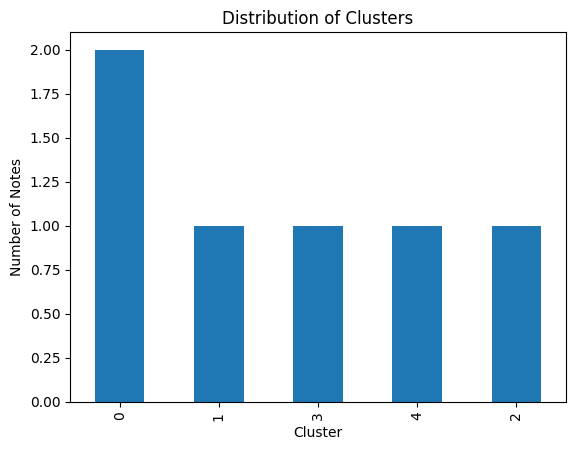

In [10]:
#distribution of clusters

import matplotlib.pyplot as plt

# Plot the distribution of clusters
cluster_distribution = CVP['cluster'].value_counts()
cluster_distribution.plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Number of Notes')
plt.title('Distribution of Clusters')
plt.show()

In [11]:
#Visualize the Clusters using t-SNE (t-distributed Stochastic Neighbor Embedding)

from sklearn.manifold import TSNE

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot
plt.figure(figsize=(12, 8))
for cluster_num in range(num_clusters):
    points = embeddings_2d[CVP['cluster'] == cluster_num]
    plt.scatter(points[:, 0], points[:, 1], label=f'Cluster {cluster_num}')
plt.legend()
plt.title("t-SNE visualization of Clinical Notes Clusters")
plt.xlabel("t-SNE feature 1")
plt.ylabel("t-SNE feature 2")
plt.show()

ValueError: perplexity must be less than n_samples

In [ ]:
### THIS CODE IS TO USED WHEN WE WOULD LIKE TO RE-TRAIN THE BERT MODEL ON OUR DATA i.e. BETTER RESULTS ###

## Load the ClinicalBERT Model
#from transformers import AutoModelForSequenceClassification

## Number of categories in label set
#num_labels = len(clinical_data['category'].unique())

#model = AutoModelForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", num_labels=num_labels)

#from torch.optim import AdamW

#optimizer = AdamW(model.parameters(), lr=5e-5, no_deprecation_warning=True)

#from torch.utils.data import DataLoader
#import torch

## DataLoader for training and validation sets
#train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=16)

## Move model to GPU if available
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model.to(device)

## Training loop
#num_epochs = 3  # You can adjust this
#for epoch in range(num_epochs):
    ## Training
    #model.train()
    #total_loss = 0
    #for batch in train_loader:
        ## Move batch to device
        #input_ids, attention_mask, labels = [b.to(device) for b in batch]

        ## Forward pass
        #outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        #loss = outputs.loss
        #total_loss += loss.item()

        ## Backward pass and optimizer step
        #optimizer.zero_grad()
        #loss.backward()
        #optimizer.step()

    #print(f"Epoch: {epoch+1}, Training Loss: {total_loss / len(train_loader)}")

    ## Validation
    #model.eval()
    #total_val_loss = 0
    #with torch.no_grad():
        #for batch in val_loader:
            #input_ids, attention_mask, labels = [b.to(device) for b in batch]
            #outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            #loss = outputs.loss
            #total_val_loss += loss.item()

    #print(f"Epoch: {epoch+1}, Validation Loss: {total_val_loss / len(val_loader)}")

##Save the Trained Model
#model.save_pretrained("./trained_clinicalbert_model")
